# scplotter to work with Multi-omics Spatial CITE-Seq data prepared by Giotto

See: <https://drieslab.github.io/Giotto_website/articles/spatial_citeseq_human_skin.html>

Go back to scplotter documentation: <https://pwwang.github.io/scplotter/>

In [1]:
library(Giotto)

# Ensure Giotto can access a python env
genv_exists <- suppressMessages(checkGiottoEnvironment())
print(genv_exists)

python_path <- file.path(Sys.getenv("HOME"), "miniconda3", "envs", "giotto_env", "bin", "python")
Sys.setenv(RETICULATE_PYTHON = python_path)

invisible(capture.output(suppressMessages(set_giotto_python_path(python_path = python_path))))

# library(scplotter)
devtools::load_all()

Loading required package: GiottoClass



Newer devel version of GiottoClass on GitHub: 0.4.8

Giotto Suite 4.2.1



[1] TRUE


ℹ Loading scplotter


In [2]:
library(Giotto)

## Set instructions
results_folder <- "data/Giotto_Spatial_CITE-Seq.results"

instructions <- createGiottoInstructions(
    save_dir = results_folder,
    save_plot = FALSE,
    show_plot = TRUE,
    return_plot = TRUE,
    python_path = python_path
)

## Provide the path to the visium folder
data_path <- "data/Giotto_Spatial_CITE-Seq"

x <- data.table::fread(file.path(data_path, "GSE213264_RAW/GSM6578065_humanskin_RNA.tsv.gz"))

spatial_coords <- data.frame(cell_ID = x$X)
spatial_coords <- cbind(spatial_coords,
                      stringr::str_split_fixed(spatial_coords$cell_ID,
                                                pattern = "x",
                                                n = 2))
colnames(spatial_coords)[2:3] = c("sdimx", "sdimy")
spatial_coords$sdimx <- as.integer(spatial_coords$sdimx)
spatial_coords$sdimy <- as.integer(spatial_coords$sdimy)
spatial_coords$sdimy <- spatial_coords$sdimy*(-1)

rna_matrix <- data.table::fread(file.path(data_path, "GSE213264_RAW/GSM6578065_humanskin_RNA.tsv.gz"))

rna_matrix <- rna_matrix[rna_matrix$X %in% spatial_coords$cell_ID,]

rna_matrix <- rna_matrix[match(spatial_coords$cell_ID, rna_matrix$X),]

rna_matrix <- t(rna_matrix[,-1])

colnames(rna_matrix) <- spatial_coords$cell_ID

protein_matrix <- data.table::fread(file.path(data_path, "GSE213264_RAW/GSM6578074_humanskin_protein.tsv.gz"))

protein_matrix <- protein_matrix[protein_matrix$X %in% spatial_coords$cell_ID,]

protein_matrix <- protein_matrix[match(spatial_coords$cell_ID, protein_matrix$X),]

protein_matrix <- t(protein_matrix[,-1])

colnames(protein_matrix) <- spatial_coords$cell_ID

my_giotto_object <- createGiottoObject(expression = list(rna = list(raw = rna_matrix),
                                                         protein = list(raw = protein_matrix)),
                                       expression_feat = list("rna", "protein"),
                                       spatial_locs = spatial_coords,
                                       instructions = instructions)

my_giotto_image <- createGiottoImage(gobject = my_giotto_object,
                                     do_manual_adj = TRUE,
                                     scale_factor = 0.5,
                                     mg_object = file.path(data_path, "skin.jpg"),
                                     negative_y = TRUE)

my_giotto_object <- addGiottoImage(gobject = my_giotto_object,
                                   images = list(my_giotto_image),
                                   spat_loc_name = "raw")

force(my_giotto_object)

python already initialized in this session
 active environment : 'giotto_env'
 python version : 3.10

do_manual_adj == TRUE
 Boundaries will be adjusted by given values.



An object of class giotto 
>Active spat_unit:  cell 
>Active feat_type:  rna 
dimensions    : 15486, 1691 (features, cells)
[SUBCELLULAR INFO]
[AGGREGATE INFO]
expression -----------------------
  [cell][rna] raw
  [cell][protein] raw
spatial locations ----------------
  [cell] raw
attached images ------------------
images      : image 


Use objHistory() to see steps and params used

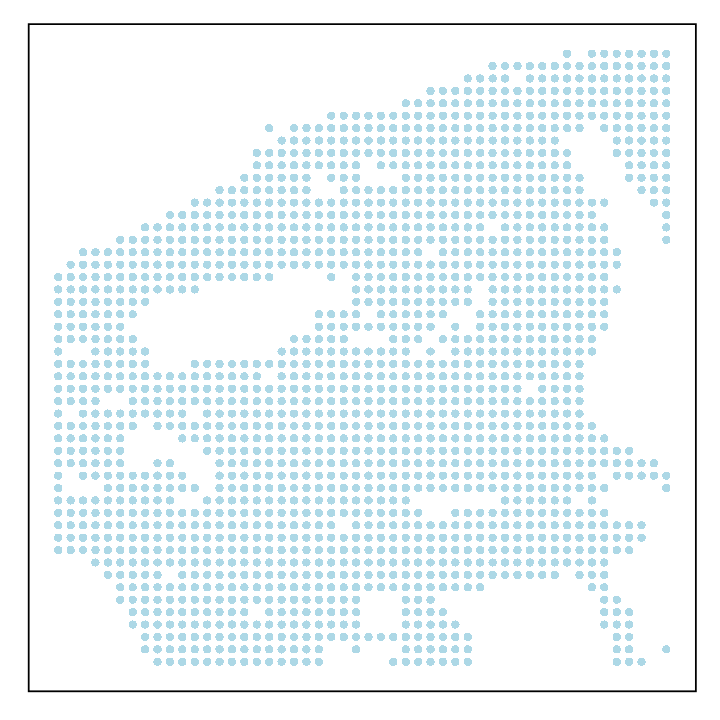

In [3]:
options(repr.plot.width = 6, repr.plot.height = 6)
# devtools::load_all()

SpatDimPlot(my_giotto_object, points_size = 2, points_color_by = "lightblue")

In [ ]:
# RNA
my_giotto_object <- filterGiotto(gobject = my_giotto_object,
                                 spat_unit = "cell",
                                 feat_type = "rna",
                                 expression_threshold = 1,
                                 feat_det_in_min_cells = 1,
                                 min_det_feats_per_cell = 1)
# Protein
my_giotto_object <- filterGiotto(gobject = my_giotto_object,
                                 spat_unit = "cell",
                                 feat_type = "protein",
                                 expression_threshold = 1,
                                 feat_det_in_min_cells = 1,
                                 min_det_feats_per_cell = 1)

# RNA
my_giotto_object <- normalizeGiotto(gobject = my_giotto_object,
                                    spat_unit = "cell",
                                    feat_type = "rna",
                                    norm_methods = "standard",
                                    scalefactor = 10000,
                                    verbose = TRUE)
# Protein
my_giotto_object <- normalizeGiotto(gobject = my_giotto_object,
                                    spat_unit = "cell",
                                    feat_type = "protein",
                                    scalefactor = 6000,
                                    verbose = TRUE)

# RNA
my_giotto_object <- addStatistics(gobject = my_giotto_object,
                                  spat_unit = "cell",
                                  feat_type = "rna")
# Protein
my_giotto_object <- addStatistics(gobject = my_giotto_object,
                                  spat_unit = "cell",
                                  feat_type = "protein",
                                  expression_values = "normalized")

# RNA
my_giotto_object <- runPCA(gobject = my_giotto_object,
                           spat_unit = "cell",
                           feat_type = "rna",
                           expression_values = "normalized",
                           reduction = "cells",
                           name = "rna.pca")
# Protein
my_giotto_object <- runPCA(gobject = my_giotto_object,
                           spat_unit = "cell",
                           feat_type = "protein",
                           expression_values = "normalized",
                           scale_unit = TRUE,
                           center = FALSE,
                           method = "factominer")

# RNA
my_giotto_object <- runUMAP(gobject = my_giotto_object,
                            spat_unit = "cell",
                            feat_type = "rna",
                            expression_values = "normalized",
                            reduction = "cells",
                            dimensions_to_use = 1:10,
                            dim_reduction_name = "rna.pca")
# Protein
my_giotto_object <- runUMAP(gobject = my_giotto_object,
                            spat_unit = "cell",
                            feat_type = "protein",
                            expression_values = "normalized",
                            dimensions_to_use = 1:10)

# RNA
my_giotto_object <- createNearestNetwork(gobject = my_giotto_object,
                                         spat_unit = "cell",
                                         feat_type = "rna",
                                         type = "sNN",
                                         dim_reduction_to_use = "pca",
                                         dim_reduction_name = "rna.pca",
                                         dimensions_to_use = 1:10,
                                         k = 20)
# Protein
my_giotto_object <- createNearestNetwork(gobject = my_giotto_object,
                                         spat_unit = "cell",
                                         feat_type = "protein",
                                         type = "sNN",
                                         name = "protein_sNN.pca",
                                         dimensions_to_use = 1:10,
                                         k = 20)

# RNA
my_giotto_object <- doLeidenCluster(gobject = my_giotto_object,
                                    spat_unit = "cell",
                                    feat_type = "rna",
                                    nn_network_to_use = "sNN",
                                    name = "leiden_clus",
                                    resolution = 1)
# Protein
my_giotto_object <- doLeidenCluster(gobject = my_giotto_object,
                                    spat_unit = "cell",
                                    feat_type = "protein",
                                    nn_network_to_use = "sNN",
                                    network_name = "protein_sNN.pca",
                                    name = "leiden_clus",
                                    resolution = 1)

my_giotto_object@cell_metadata$cell$rna$leiden_clus <- as.character(my_giotto_object@cell_metadata$cell$rna$leiden_clus)
my_giotto_object@cell_metadata$cell$protein$leiden_clus <- as.character(my_giotto_object@cell_metadata$cell$protein$leiden_clus)

my_giotto_object <- createNearestNetwork(gobject = my_giotto_object,
                                         spat_unit = "cell",
                                         feat_type = "rna",
                                         type = "kNN",
                                         dim_reduction_name = "rna.pca",
                                         name = "rna_kNN.pca",
                                         dimensions_to_use = 1:10,
                                         k = 20)
my_giotto_object <- createNearestNetwork(gobject = my_giotto_object,
                                         spat_unit = "cell",
                                         feat_type = "protein",
                                         type = "kNN",
                                         name = "protein_kNN.pca",
                                         dimensions_to_use = 1:10,
                                         k = 20)

my_giotto_object <- runWNN(my_giotto_object,
                        #    modality_1 = "rna",
                        #    modality_2 = "protein",
                        #    pca_name_modality_1 = "rna.pca",
                        #    pca_name_modality_2 = "protein.pca",
                           k = 20)

my_giotto_object <- runIntegratedUMAP(my_giotto_object)
                                    #   modality1 = "rna",
                                    #   modality2 = "protein")

my_giotto_object <- doLeidenCluster(gobject = my_giotto_object,
                                    spat_unit = "cell",
                                    feat_type = "rna",
                                    nn_network_to_use = "kNN",
                                    network_name = "integrated_kNN",
                                    name = "integrated_leiden_clus",
                                    resolution = 0.7)

my_giotto_object <- createSpatialNetwork(gobject = my_giotto_object,
                                         method = "kNN",
                                         k = 6,
                                         maximum_distance_knn = 5,
                                         name = "spatial_network")

rank_spatialfeats <- binSpect(my_giotto_object,
                     bin_method = "rank",
                     calc_hub = TRUE,
                     hub_min_int = 5,
                     spatial_network_name = "spatial_network")


completed 1: preparation

completed 2: subset expression data

completed 3: subset spatial locations

completed 4: subset cell metadata

completed 5: subset feature metadata

completed 6: subset spatial network(s)

completed 7: subsetted dimension reductions

completed 8: subsetted nearest network(s)

completed 9: subsetted spatial enrichment results




Feature type:  rna 
Number of cells removed:  0  out of  1691 
Number of feats removed:  363  out of  15486 


completed 1: preparation

completed 2: subset expression data

completed 3: subset spatial locations

completed 4: subset cell metadata

completed 5: subset feature metadata

completed 6: subset spatial network(s)

completed 7: subsetted dimension reductions

completed 8: subsetted nearest network(s)

completed 9: subsetted spatial enrichment results




Feature type:  protein 
Number of cells removed:  0  out of  1691 
Number of feats removed:  0  out of  283 


first scale feats and then cells



Setting expression [cell][rna] normalized

Setting expression [cell][rna] scaled

Warning message in .rna_standard_normalization(gobject = gobject, raw_expr = raw_expr, :
“Caution: Standard normalization was developed for RNA data 
”
first scale feats and then cells

Setting expression [cell][protein] normalized

Setting expression [cell][protein] scaled

calculating statistics for "normalized" expression

calculating statistics for "normalized" expression

"hvf" was not found in the gene metadata information.
 all genes will be used.

Setting dimension reduction [cell][rna] rna.pca

"hvf" was not found in the gene metadata information.
 all genes will be used.

Setting dimension reduction [cell][protein] protein.pca

Setting dimension reduction [cell][rna] umap

Setting dimension reduction [cell][protein] protein.umap

The NN network name was not specified, default to the
 first: "rna_kNN.pca"

The NN network name was not specified, default to the
 first: "protein_kNN.pca"

Calculatin

In [45]:
im <- terra::rast(as.numeric(my_giotto_object@images$image@mg_object[[1]]), extent = c(1, 50, -50, 1))
im

class       : SpatRaster 
dimensions  : 2700, 2704, 3  (nrow, ncol, nlyr)
resolution  : 0.0181213, 0.01888889  (x, y)
extent      : 1, 50, -50, 1  (xmin, xmax, ymin, ymax)
coord. ref. :  
source(s)   : memory
names       : lyr.1, lyr.2, lyr.3 
min values  :     0,     0,     0 
max values  :     1,     1,     1 

In [33]:
terra::res(im)

[1] 1 1

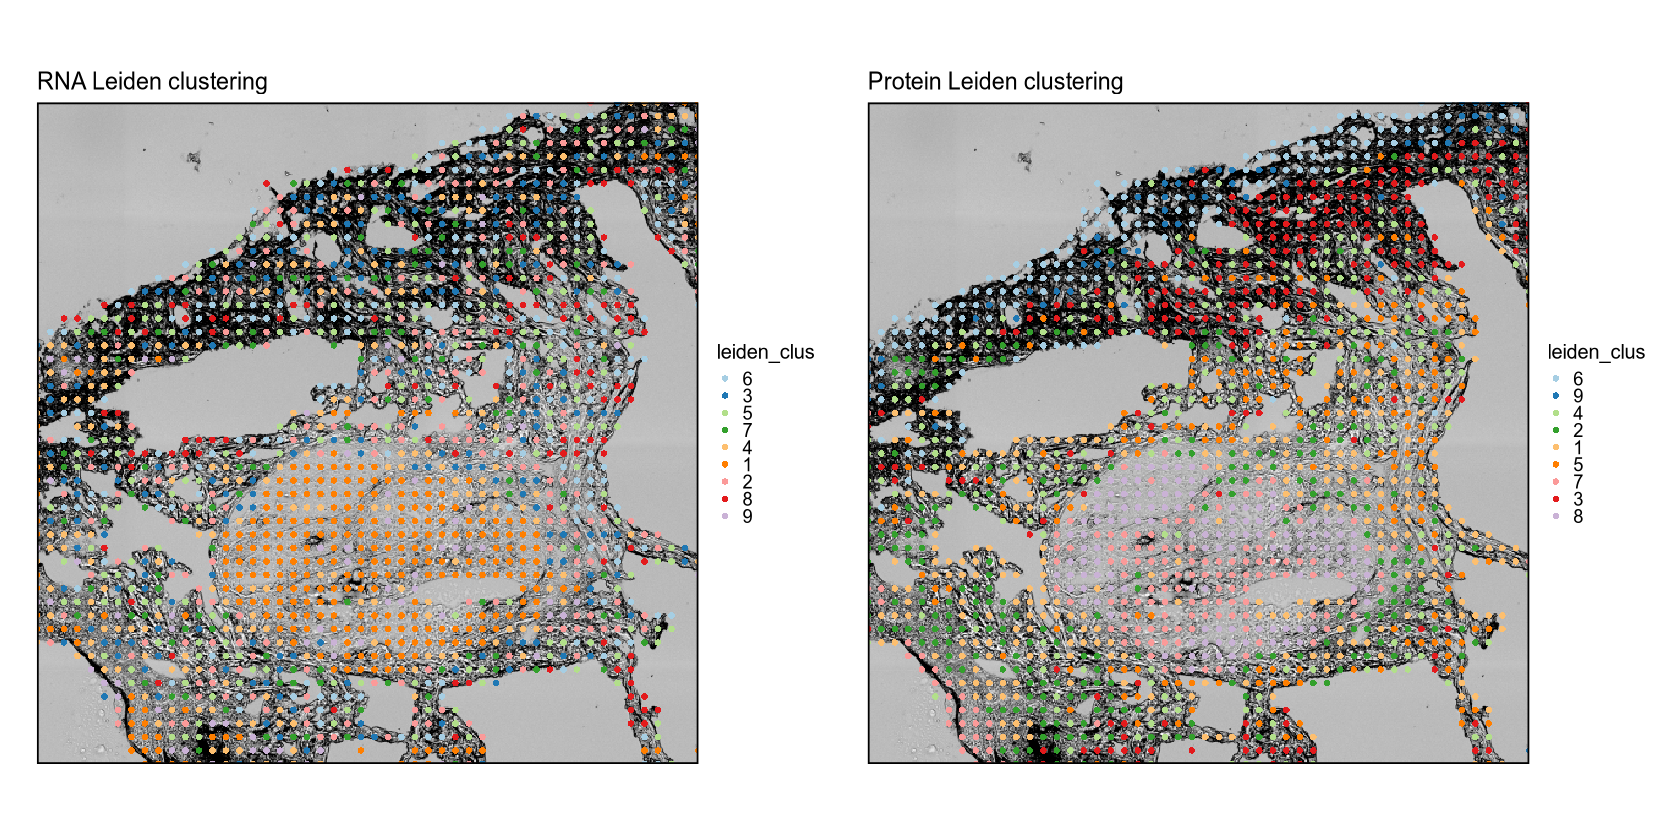

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 7)
# devtools::load_all()

p1 <- SpatDimPlot(my_giotto_object, image = TRUE, group_by = "leiden_clus",
    title = "RNA Leiden clustering")
p2 <- SpatDimPlot(my_giotto_object, image = TRUE, group_by = "leiden_clus",
    spat_unit = "cell", feat_type = "protein", title = "Protein Leiden clustering")

p1 + p2

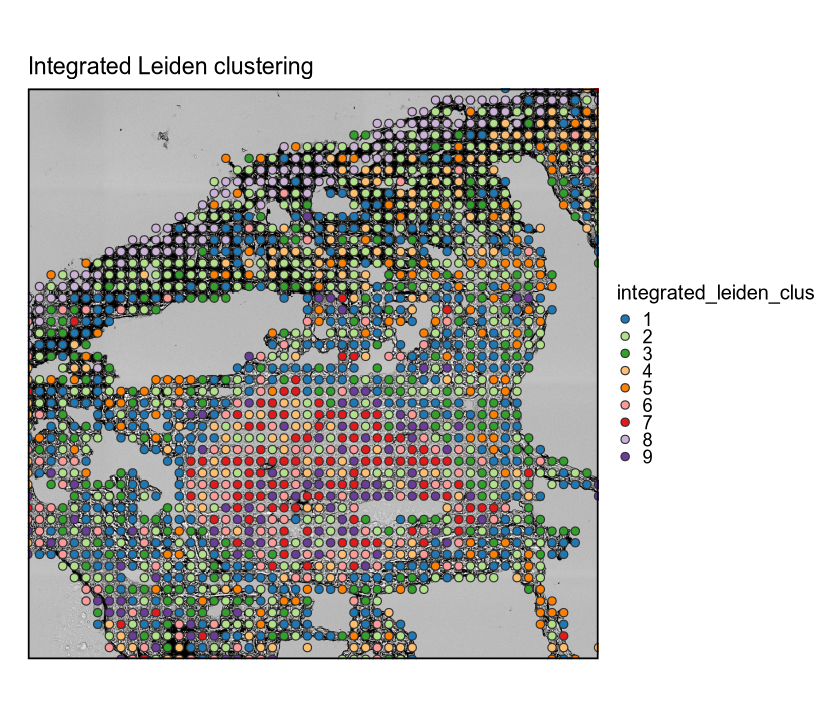

In [55]:
options(repr.plot.width = 7, repr.plot.height = 6)
# devtools::load_all()

my_giotto_object@cell_metadata$cell$rna$integrated_leiden_clus <- as.character(my_giotto_object@cell_metadata$cell$rna$integrated_leiden_clus)
# change the order
my_giotto_object@cell_metadata$cell$rna$integrated_leiden_clus <- factor(my_giotto_object@cell_metadata$cell$rna$integrated_leiden_clus,
    levels = c("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"))

p1 <- SpatDimPlot(my_giotto_object, image = TRUE, group_by = "integrated_leiden_clus",
    title = "Integrated Leiden clustering", points_shape = 21, points_size = 2,
    points_border_color = "grey20")

p1

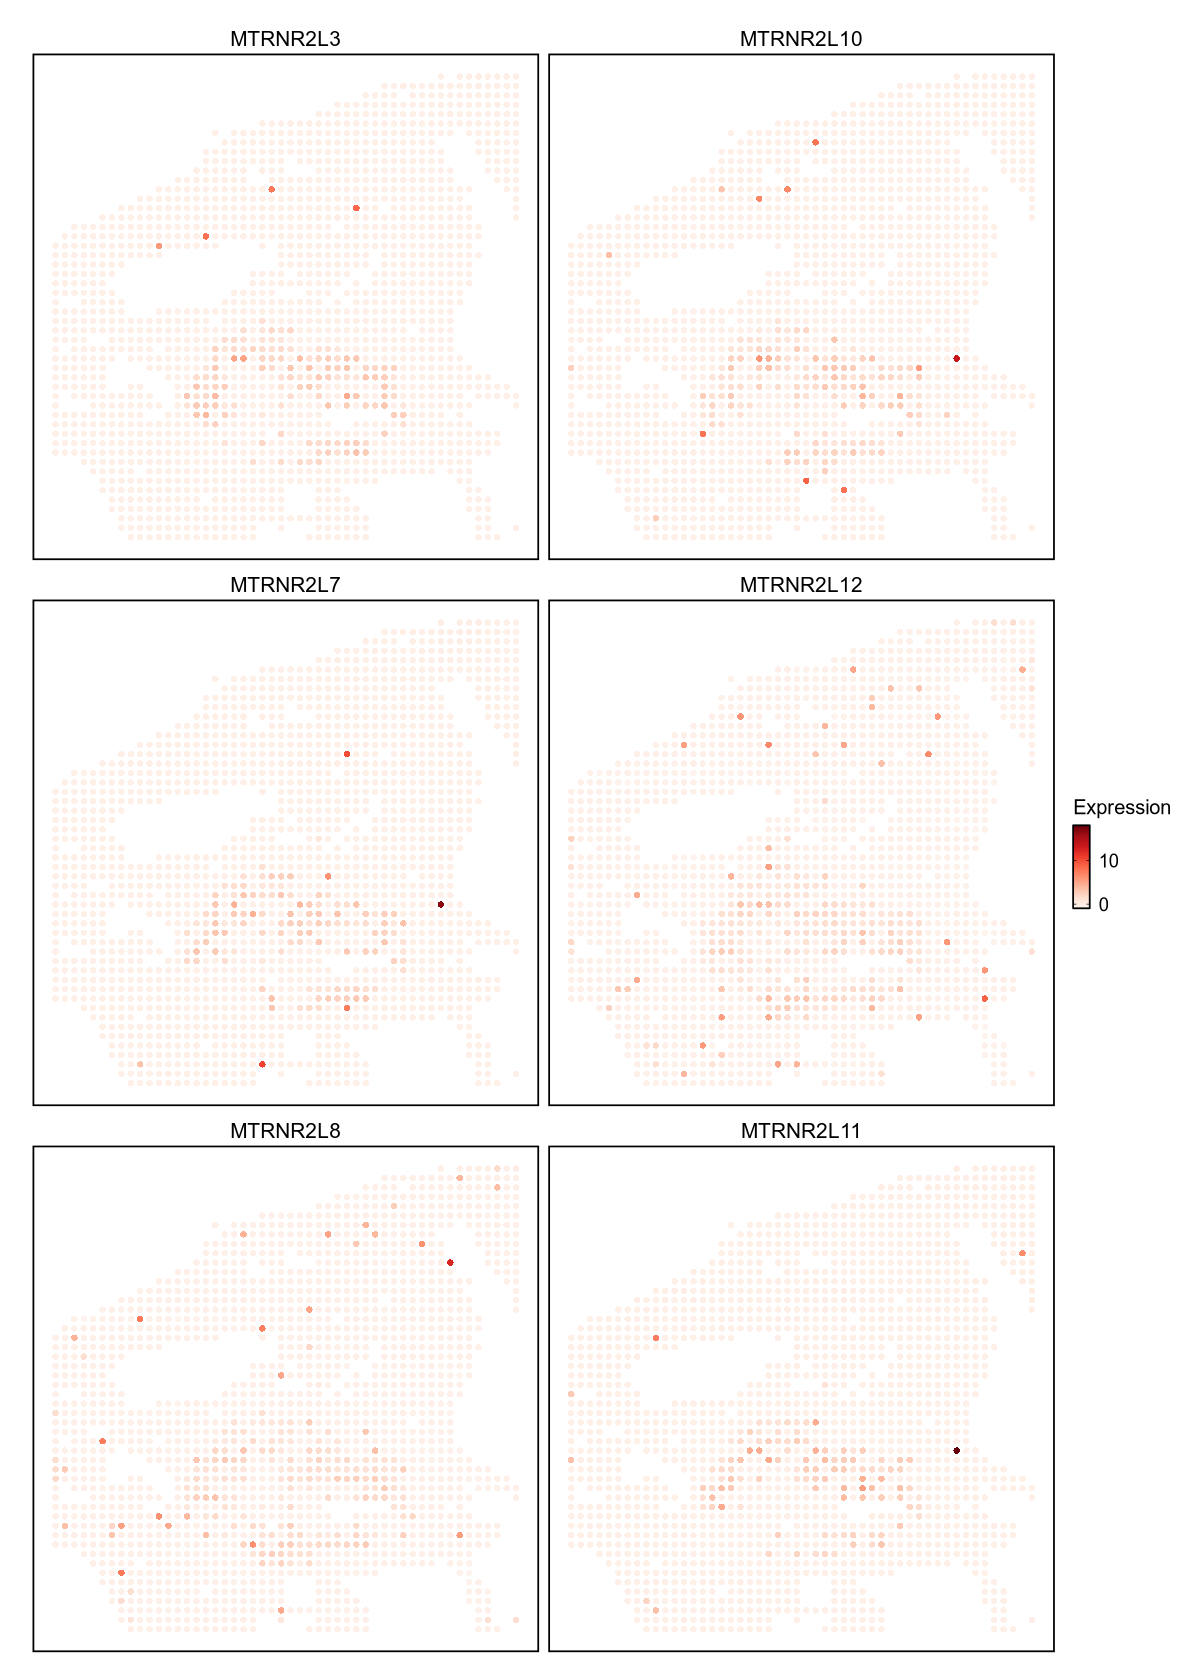

In [60]:
options(repr.plot.width = 10, repr.plot.height = 14)

SpatFeaturePlot(my_giotto_object,
               layer = "scaled",
               features = rank_spatialfeats$feats[1:6],
               points_palette = "Reds",
               facet_ncol = 2)

In [2]:
x <- sessionInfo()
x <- capture.output(print(x))
# hide the BLAS/LAPACK paths
x <- x[!startsWith(x, "BLAS/LAPACK:")]
cat(paste(x, collapse = "\n"))

R version 4.4.3 (2025-02-28)
Platform: x86_64-conda-linux-gnu
Running under: Red Hat Enterprise Linux 8.10 (Ootpa)

Matrix products: default

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=C              
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Chicago
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] scplotter_0.4.0   Giotto_4.2.1      GiottoClass_0.4.7

loaded via a namespace (and not attached):
  [1] fs_1.6.6                    matrixStats_1.5.0          
  [3] spatstat.sparse_3.1-0       bitops_1.0-9               
  [5] devtools_2.4.5              httr_1.4.7                 
  [7] RColorBrewer_1.1-3 